In [37]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [38]:
from pathlib import Path
from py_module.data_display import get_data_paths, display_nomenclature, display_samples, display_all_with_semantic_class, display_all

In [39]:
#general 
import os
import numpy as np
import json
import random
from pathlib import Path 


#deep learning
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.callbacks.progress.tqdm_progress import TQDMProgressBar
from pytorch_lightning import Trainer, seed_everything
try:
  from pytorch_lightning.utilities.distributed import rank_zero_only
except ImportError:
  from pytorch_lightning.utilities.rank_zero import rank_zero_only  

import albumentations as A

#flair-one baseline modules 
from py_module.utils import load_data, subset_debug
from py_module.datamodule import OCS_DataModule
# from py_module.model import SMP_Unet_meta
from py_module.task_module import SegmentationTask
from py_module.writer import PredictionWriter

In [40]:
!nvidia-smi

Thu Dec 29 19:00:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.56.06    Driver Version: 520.56.06    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:27:00.0 Off |                    0 |
| N/A   33C    P0    37W / 250W |      2MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  Off  | 00000000:A3:00.0 Off |                    0 |
| N/A   

In [41]:
##############################################################################################
# paths and naming
path_data = "./dataset/" # toy (or full) dataset folder
# path_data = './toy_dataset_flair-one/'

path_metadata_file = "./dataset/metadata/flair-one_metadata.json" # json file containing the metadata

out_folder = "./models_output/" # output directory for logs and predictions.
##############################################################################################

##############################################################################################
# tasking
use_weights = True 
class_weights = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0]

use_metadata = True
use_augmentation = True
##############################################################################################

##############################################################################################
# training hyper-parameters
batch_size = 16
learning_rate = 2e-2 #0.02
num_epochs = 100
##############################################################################################

##############################################################################################
# computational ressources
accelerator = 'gpu' # set to 'cpu' if GPU not available
gpus_per_node = 1 # set to 1 if mono-GPU
num_nodes = 1 # set to 1 if mono-GPU
strategy = None # Put this parameter to None if train on only one GPU or on CPUs. If multiple GPU, set to 'ddp'
num_workers = 64
##############################################################################################

##############################################################################################
# display
enable_progress_bar = True
progress_rate = 10 #tqdm update rate during training 
##############################################################################################
arch='unetplusplus'
encoder_name='resnet152'
out_model_name = ""+arch+"_"+encoder_name+"_lr_"+str(learning_rate)+"_bs_"+str(batch_size)+"_ep_"+str(num_epochs) # to keep track
chk_path='./models_output/unetplusplus_resnet151_lr_0.02_bs_16_ep_100/checkpoints/ckpt-epoch=01-val_loss=0.77_unetplusplus_resnet151_lr_0.02_bs_16_ep_100.ckpt'

In [42]:
out_model_name='unetplusplus_resnet151_lr_0.02_bs_16_ep_100'

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

class mtd_MLP(nn.Module):
    """ 
    Light MLP to encode metadata
    
    """
    def __init__(self):
        super(mtd_MLP, self).__init__()

        self.enc_mlp = nn.Sequential(
            nn.Linear(45, 64),
            nn.Dropout(0.4),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.Dropout(0.4),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
            nn.Dropout(0.4),
            nn.ReLU()        
        )            
        
    def forward(self, x):
        x = self.enc_mlp(x)
        return x    



class SMP_Unet_meta(nn.Module):
    """ 
    Pytorch segmentation U-Net with ResNet34 (default) 
    with added metadata information at encoder output
    
    """    
    def __init__(self,
                 n_channels, 
                 n_classes,
                 use_metadata=True,
                 arch="unet",
                 encoder_name="resnet101"
                 ):
        super(SMP_Unet_meta, self).__init__()
        
        self.seg_model = smp.create_model(arch=arch, encoder_name=encoder_name, classes=n_classes, in_channels=n_channels)
        self.use_metadata = use_metadata
        if use_metadata == True:
            self.enc = mtd_MLP()
    
    def resolve_state_dict(self, state_dict, string_to_remove='model.seg_model.'):
        n = len(string_to_remove) 
        
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            if k == "criterion.weight":
                continue
            name = k[n:] # remove
            new_state_dict[name] = v

        return new_state_dict
        
    def load_model(self, path, map_location='cuda:0'):
        state_dict = torch.load(path, map_location=map_location)
        # print(state_dict)
        state_dict = state_dict['state_dict'] # take only the state_dict values
        state_dict = self.resolve_state_dict(state_dict) # remove model.seg_model.
        # print("------------------------")
        # print(state_dict)
        self.seg_model.load_state_dict(state_dict)
        print('Model loaded!')
        
    def forward(self, x, met):
        
        if self.use_metadata == True:
            feats = self.seg_model.encoder(x)
            x_enc = self.enc(met)
            x_enc = x_enc.unsqueeze(1).unsqueeze(-1).repeat(1,2048,1,16)              
            feats[-1] = torch.add(feats[-1], x_enc)     
            output = self.seg_model.decoder(*feats)
            output = self.seg_model.segmentation_head(output)
        else:
            output = self.seg_model(x)

        return output

## <font color='#90c149'>Dataloaders</font>

<br/><hr>

The following cell loads the data into a pytorch-lighning DataModule (`OCS_Datamodule`). If `use_metadata = True` and `use_augmentation = True`, they are also integrated in the DataModule. 

We fix the global seed (python random, torch, numpy) with `seed_eveything`.

`@rank_zero_only` is needed if logging and callbacks are used with multi-GPU processing, preventing synchronization from concurrent processes.

<hr><br/>

In [44]:
out_dir = Path(out_folder, out_model_name)
out_dir.mkdir(parents=True, exist_ok=True)

seed_everything(2022, workers=True)

@rank_zero_only
def step_loading(path_data, path_metadata_file: str, use_metadata: bool) -> dict:
    print('+'+'-'*29+'+', '   LOADING DATA   ', '+'+'-'*29+'+')
    train, val, test = load_data(path_data, path_metadata_file, use_metadata=use_metadata)
    return train, val, test


@rank_zero_only
def print_recap():
    print('\n+'+'='*80+'+',f"{'Model name: '+out_model_name : ^80}", '+'+'='*80+'+', f"{'[---TASKING---]'}", sep='\n')
    for info, val in zip(["use weights", "use metadata", "use augmentation"], [use_weights, use_metadata, use_augmentation]): print(f"- {info:25s}: {'':3s}{val}")
    print('\n+'+'-'*80+'+', f"{'[---DATA SPLIT---]'}", sep='\n')
    for split_name, d in zip(["train", "val", "test"], [dict_train, dict_val, dict_test]): print(f"- {split_name:25s}: {'':3s}{len(d['IMG'])} samples")
    print('\n+'+'-'*80+'+', f"{'[---HYPER-PARAMETERS---]'}", sep='\n')
    for info, val in zip(["batch size", "learning rate", "epochs", "nodes", "GPU per nodes", "accelerator", "workers"], [batch_size, learning_rate, num_epochs, num_nodes, gpus_per_node, accelerator, num_workers]): print(f"- {info:25s}: {'':3s}{val}")        
    print('\n+'+'-'*80+'+', '\n')

dict_train, dict_val, dict_test = step_loading(path_data, path_metadata_file, use_metadata=use_metadata)  
print_recap()


dm = OCS_DataModule(
    dict_train=dict_train,
    dict_val=dict_val,
    dict_test=dict_test,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
    num_classes=13,
    num_channels=5,
    use_metadata=use_metadata)

Global seed set to 2022


+-----------------------------+    LOADING DATA    +-----------------------------+


# Model

In [18]:
model = SMP_Unet_meta(n_channels=5, n_classes=13, use_metadata=False, arch=arch, encoder_name=encoder_name)

In [19]:
model.load_model(chk_path, map_location='cuda:0')

Model loaded!


In [20]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

if use_weights == True:
    with torch.no_grad():
        class_weights = torch.FloatTensor(class_weights)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion = nn.CrossEntropyLoss()
    
seg_module = SegmentationTask(
    model=model,
    num_classes=dm.num_classes,
    criterion=criterion,
    optimizer=optimizer,
    use_metadata=use_metadata
)


In [21]:
#### instanciation of  Trainer
trainer = Trainer(
    accelerator=accelerator,
    devices=gpus_per_node,
    strategy=strategy,
    num_nodes=num_nodes,
    max_epochs=num_epochs,
    num_sanity_val_steps=0,
    enable_progress_bar = enable_progress_bar,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## <font color='#90c149'>Inference and predictions export</font>

<br/><hr>

For inference, we define a new callback, `PredictionWriter`, which is used to export the predictions on the test dataset.<br/><br/>
<font color='#90c149'>Note:</font> the callback exports the files with the mandotary formatting of outputs (files named <font color='red'><b> PRED_{ID].tif</b></font>, with datatype <font color='red'><b>uint8</b></font> and <font color='red'><b>LZW</b></font> compression), using Pillow.
Check the <font color='#D7881C'><em>writer.py</em></font> file for details.<br/><br/>

We instantiate a new `Trainer` with this newly defined callback and call predict.
<hr><br/>

In [29]:
writer_callback = PredictionWriter(        
    output_dir=os.path.join(out_dir, "predictions"+"_"+out_model_name),
    write_interval="batch",
)

#### instanciation of prediction Trainer
trainer = Trainer(
    accelerator=accelerator,
    devices=gpus_per_node,
    strategy=strategy,
    num_nodes=num_nodes,
    callbacks = [writer_callback],
    enable_progress_bar = enable_progress_bar,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [30]:
trainer.predict(seg_module, datamodule=dm)

@rank_zero_only
def print_finish():
    print('--  [FINISHED.]  --', f'output dir : {out_dir}', sep='\n')
print_finish()

Missing logger folder: /home/infres/abounhar/flair_challenge_sattelite_image_semantic_segmentation/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 50/50 [00:04<00:00, 12.39it/s]
--  [FINISHED.]  --
output dir : models_output/unetplusplus_resnet151_lr_0.02_bs_16_ep_100


## <font color='#90c149'>Visual checking of predictions</font>

<br/><hr>

<font color='#90c149'>For the test set, obviously, you do not have access to the masks.</font> Nevertheless, we can visually display some predictions alongside the RGB images.<br/><br/>

First, we create lists containing the paths to the test RGB images (`images_test`) as well as the predicted semantic segmentation masks (`predictions`).<br/><br/>



We then display some random couples of predictions together with their corresponding aerial RGB images.<br/><br/>

<font color='#90c149'><em>Note 1</em></font>: if you are using the toy dataset, don't expect accurate predictions. A set of $200$ training samples will give limited results.<br/> 
<font color='#90c149'><em>Note 2</em></font>: rasterio will yield a <em>NotGeoreferencedWarning</em> regarding the predictions files. This is normal as the prediction files have been written without any geographical information, which is expected by rasterio. This kind of information is not important for assessing the model outputs, so we can just omit the warning.
<hr><br/>

In [31]:
from py_module.data_display import display_predictions, get_data_paths

images_test = sorted(list(get_data_paths(Path(path_data,'test'), 'IMG*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
# images_test = sorted(list(get_data_paths(Path(path_data,'train'), 'IMG*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
predictions = sorted(list(get_data_paths(Path(out_dir, "predictions"+'_'+out_model_name), 'PRED*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))

In [32]:
len(predictions)

50

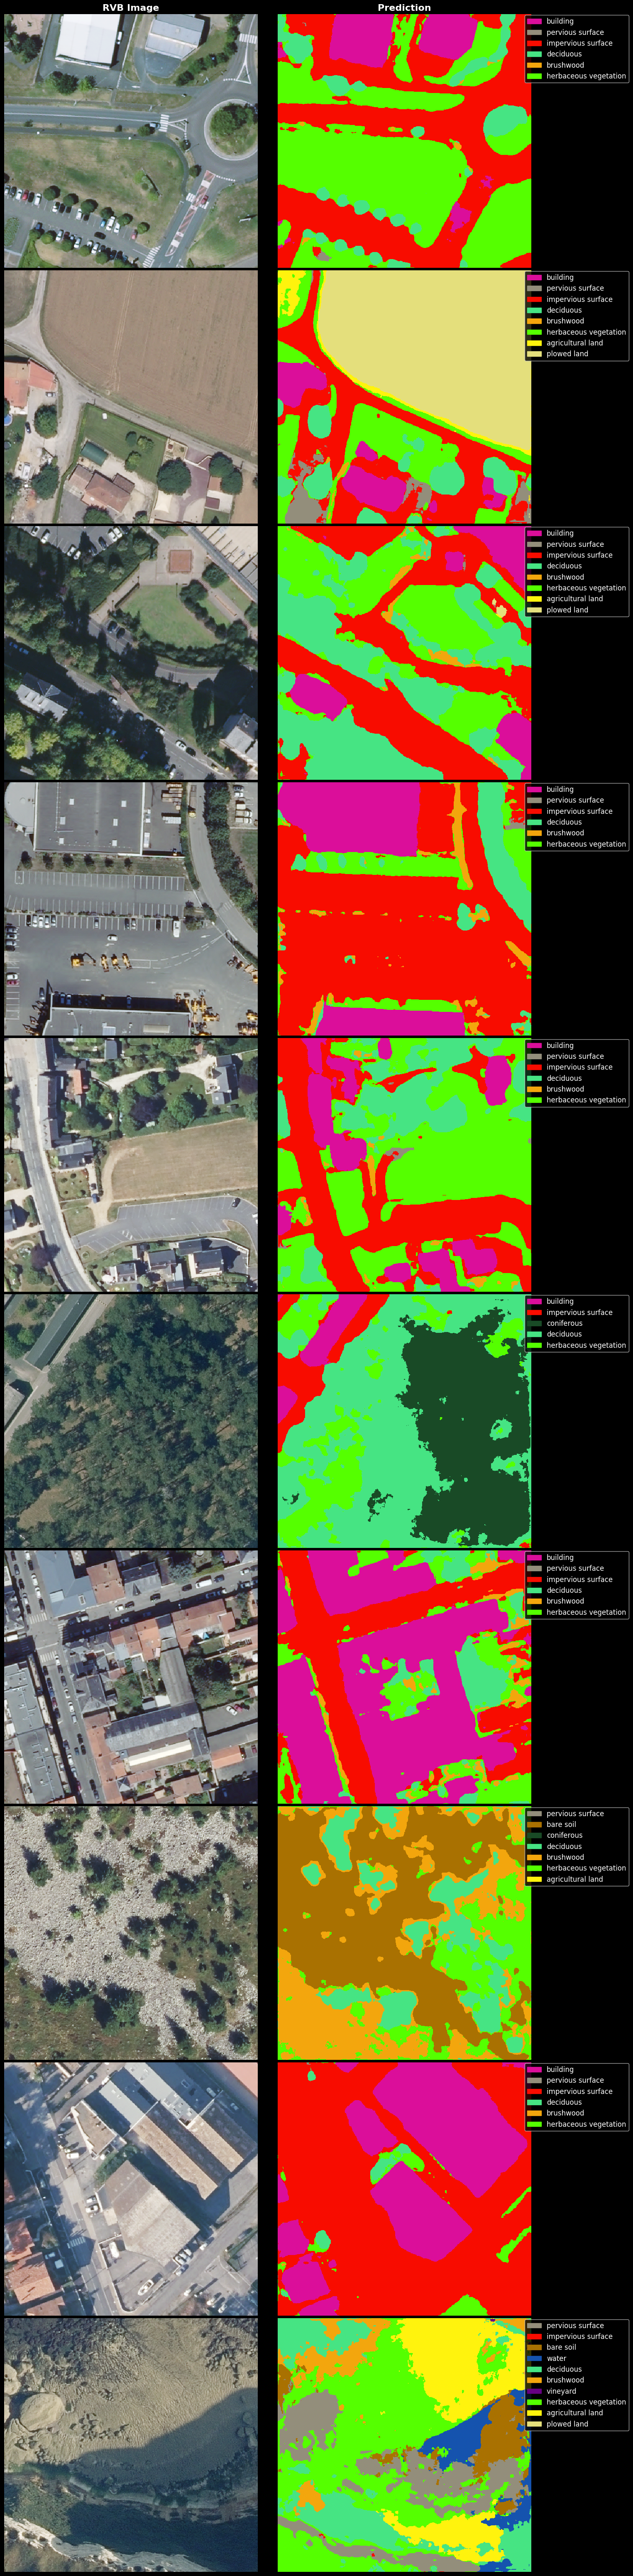

In [33]:
display_predictions(images_test, predictions, nb_samples=10)

## <font color='#90c149'>Metric calculation: mIoU</font>

<br/><hr>

As mentioned before, the masks of the test set are not available. However, the following cell describes the code that is used to calculate the metric used over the test set and to consequently rank the best models. Again, the toy dataset contains $50$ test pastches, while the full FLAIR-one dataset contains $15,700$ test patches.<br/><br/>

The calculation of the mean Intersection-over-Union (`mIou`) is based on the confusion matrix $C$, which is determined for each test patch. The confusion matrices are subsequently summed providing the confusion matrix describing the test set. Per-class IoU, defined as the ratio between true positives divided by the sum of false positives, false negatives and true positives is calculated from the summed confusion matrix as follows: <br/><br/>
    $$
    IoU_i = \frac{C_{i,i}}
    {C_{i,i} + \sum_{j \neq i}\left(C_{i,j} + C_{j,i} \right)} = \frac{TP}{TP+FP+FN}
    $$
<br>
The final `mIou` is then the average of the per-class IoUs. 


<font color='#90c149'><em>Note:</em></font> as the <font color='#90c149'><em>'other'</em></font> class is <font color='#90c149'>not well defined (void)</font>, its IoU is <font color='#90c149'>removed</font> and therefore does not contribute to the calculation of the `mIou`. In other words,  the remaining per-class IoUs (all except 'other') are averaged by 12 and not 13 to obtain the final `mIou`.</font>

<hr><br/>

In [142]:
import re
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix


def generate_miou(path_truth: str, path_pred: str) -> list:
  
    #################################################################################################
    def get_data_paths (path, filter):
        for path in Path(path).rglob(filter):
             yield path.resolve().as_posix()  
                
    def calc_miou(cm_array):
        m = np.nan
        with np.errstate(divide='ignore', invalid='ignore'):
            ious = np.diag(cm_array) / (cm_array.sum(0) + cm_array.sum(1) - np.diag(cm_array))
        m = np.nansum(ious[:-1]) / (np.logical_not(np.isnan(ious[:-1]))).sum()
        return m.astype(float), ious[:-1]      

    #################################################################################################
                       
    truth_images = sorted(list(get_data_paths(Path(path_truth), 'MSK*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
    preds_images  = sorted(list(get_data_paths(Path(path_pred), 'PRED*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
    print('truth images :', len(truth_images))
    print('preds_images images :', len(preds_images))
    if len(truth_images) != len(preds_images): 
        print('[WARNING !] mismatch number of predictions and test files.')
    if truth_images[0][-10:-4] != preds_images[0][-10:-4] or truth_images[-1][-10:-4] != preds_images[-1][-10:-4]: 
        print('[WARNING !] unsorted images and masks found ! Please check filenames.') 
        
    patch_confusion_matrices = []

    for u in range(len(truth_images)):
        target = np.array(Image.open(truth_images[u]))-1 # -1 as model predictions start at 0 and turth at 1.
        target[target>12]=12  ### remapping masks to reduced baseline nomenclature.
        preds = np.array(Image.open(preds_images[u]))         
        patch_confusion_matrices.append(confusion_matrix(target.flatten(), preds.flatten(), labels=list(range(13))))

    sum_confmat = np.sum(patch_confusion_matrices, axis=0)
    mIou, ious = calc_miou(sum_confmat) 

    return mIou, ious


if __name__ == "__main__":  
   truth_msk = './toy_dataset_flair-one/train'
   pred_msk  = './models_output/flair-one-baseline_argu/predictions_unetplusplus_resnet151_lr_0.02_bs_16_ep_100'
   mIou = generate_miou(truth_msk, pred_msk)

truth images : 0
preds_images images : 0


IndexError: list index out of range

<br/><br/><br/><br/>

### <center><strong>For any feedback, request, suggestion or simply to say hi, we are reachable at : ai-challenge@ign.fr !</strong></center>
<br/>
<font size=2.5> <b>@IGN, Nov. 2022</b></font>
<img src="https://drive.google.com/uc?export=view&id=14clxUsTGj7i6oXt6q9FQeaxzjIi3biI2" alt="Drawing"  width="100%"/>